In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab3.ipynb")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from resources.hashutils import *

---

<h1><center>SDSE Lab 3 <br><br> K-means clustering </center></h1>

---

# 1) Load the data
We load the dataset from the file `'resources/data2d.pickle'`. The data matrix is called `D`. Save the number of samples (rows) as `N` and the number of features (columns) as `d`.

In [3]:
with open("resources/data2d.pickle", "rb") as f:
    D = pickle.load(f)
N = len(D)
d = len(D[0])

In [4]:
grader.check("q1")

q1 results: All test cases passed!

# 2) Scatter plot
Create a scatter plot with the first column of `D` along the x-axis and the second column along the y-axis. Use `plt.axis('equal')` to force the two axes to have the same scale. This is important for correct visualization of the Euclidean distances between points. Your figure should look like the one below.

Food for thought: How many clusters do you see?

<img src="resources/2.png" />

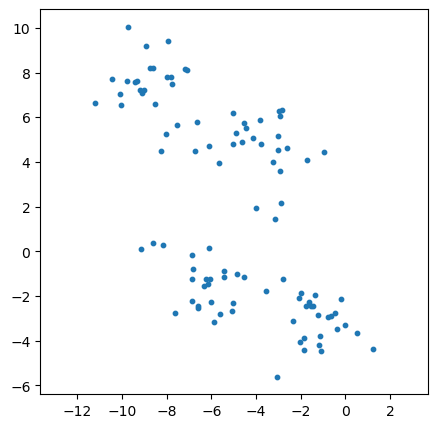

In [5]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.axis('equal')
xs = D.transpose()[0]
ys = D.transpose()[1]
ax.scatter(xs, ys, s=10)

# 3) Random placement of centroids
Write a function that takes an integer `K` and the data matrix `D` as inputs, and returns `K` centroids randomly placed within the box spanned by the columns of `D`. The shape of the return value should be `(K,d)`. 

The template also takes a third optional parameter. This is used by the autograder to ensure repeatable results. 

**Note**: You should use `stats.uniform.rvs(loc=..., scale=..., size=...)` to generate random centroid placements. 

In [6]:
def initialize_centroids(K,D,random_seed=None):
    if random_seed is not None:
        np.random.seed(seed=random_seed)
    d = D.shape[1]
    C = np.empty((K,d))
    for i in range(d):
        min_val = D[:, i].min()
        max_val = D[:, i].max()
        C[:, i] = stats.uniform.rvs(loc=min_val, scale=max_val - min_val, size=K)
    return C

In [7]:
grader.check("q3")

q3 results: All test cases passed!

# 4) Compute the assignment for given centroids
Write a function that takes the data matrix `X` (shape `(N,D)`) and centroid locations `C` (shape `(K,D)`) as inputs, and returns an assignment matrix `gamma`. `gamma` should be a numpy array with shape `(N,K)`. Each row of `gamma` should contain `K-1` `False` values and one `True` value in the position corresponding to the centroid that is nearest to that data point (Euclidean distance). 

Hint: `np.argmin`.

In [8]:
def assign_samples_to_nearest_centroid(D,C):
    N = D.shape[0]
    K = C.shape[0]
    gamma = np.zeros((N,K),dtype=bool)  # Initialized to all False
    distances = np.linalg.norm(D[:, np.newaxis] - C, axis=2)
    nearest_centroids = np.argmin(distances, axis=1)
    gamma[np.arange(N), nearest_centroids] = True
    return gamma

In [9]:
C4 = initialize_centroids(4,D,random_seed=234)
gamma4 = assign_samples_to_nearest_centroid(D,C4)

In [10]:
C8 = initialize_centroids(8,D,random_seed=324)
gamma8 = assign_samples_to_nearest_centroid(D,C8)

In [11]:
grader.check("q4")

q4 results: All test cases passed!

# 5) Plot data, centroids, assignment
Write a function that takes as input the data matrix `D`, a centroids matrix `C`, and an assignment matrix `gamma`, and creates a scatter plot similar to the one shown here. The centroids should be indicated with a large dot, and the data samples should be color-coded according to their cluster membership. Your plot may not look identical to this one due to the random placement of the centroids.

<img src="resources/5.png" />


In [12]:
def plot_scatter(D, C, gamma):
    K = C.shape[0]
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()
    for k in range(K):
        ax.plot(D[gamma[:, k]][:, 0],D[gamma[:, k]][:, 1],'.', markersize=10)  # plot data assigned to cluster k
    ax.plot(C[:, 0], C[:, 1], 'o', markersize=10)  # plot the centroids
    ax.axis('equal')

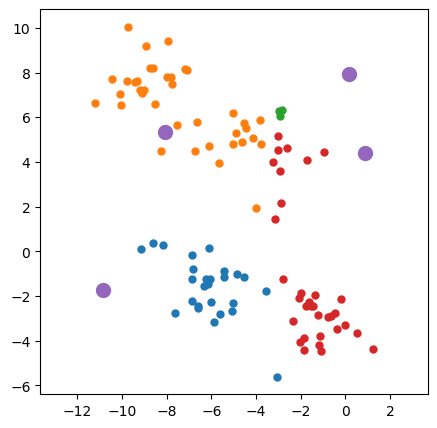

In [13]:
plot_scatter(D, C4, gamma4)

# 6) Compute the centroids for a given assignment
Write a function that takes the assignment `gamma` and the data matrix `D` and returns centroids placed at the mean of each cluster. The return value should be a numpy array with shape `(K,D)`.

In [14]:
def place_centroids(gamma, D):
    K = gamma.shape[1]
    d = D.shape[1]
    C = np.empty((K,d))
    for k in range(K):
        assigned_points = D[gamma[:, k]]
        if len(assigned_points) > 0:
            C[k] = np.mean(assigned_points, axis=0)
        else:
            C[k] = np.zeros(d) 
    return C

In [15]:
newC4 = place_centroids(gamma4, D)

In [16]:
grader.check("q6")

q6 results: All test cases passed!

# 7) Code K-means
Now we will implement the K-means algorithm using the methods that we've coded so far. Implement the K-means algorithm described in class. 

The function `run_kmeans` takes the dataset `D` and initial centroids `C` as input. It returns the final placement of the centroids `C`, and the assignment matrix `gamma`. There are two stopping conditions:
+ Stop and return `C=None` and `gamma=None` if any of the clusters becomes empty. 
+ Stop if the assignment matrix does not change from one iteration to the next. 

In [17]:
def run_kmeans(D,C):

    done = False
    first = True
    gammaold = None
        
    while not done:
        
        # compute assignment (E step)
        gamma = assign_samples_to_nearest_centroid(D, C)
        
        # place centroids (M step)
        C = place_centroids(gamma, D)
        
        # Break if any of the clusters are empty
        # Return C=None and gamma=None
        if any([np.all(gamma[:, k] == False) for k in range(gamma.shape[1])]):
            return None, None
            
        # Break if there is no change in the assignment
        if not first and (C is None or gamma is None or np.array_equal(gammaold, gamma)):
            done = True
            
        # update gamma
        gammaold = gamma
        first = False
            
            
    return C, gamma

In [18]:
optC4, optgamma4 = run_kmeans(D,C4)

In [19]:
optC8, optgamma8 = run_kmeans(D,C8)

In [20]:
grader.check("q7")

q7 results: All test cases passed!

# 8) Evaluate the cost function 
Write a function that evaluates the cost function for a given dataset `D`, centroid placement `C`, and assignment matrix `gamma`. The cost function is the sum of the squared distances from each point (row in `D`) to its assigned centroid (row in `C`). The function should return `np.nan` if `C` is `None`.

In [21]:
def eval_cost(X,C,gamma):
    if C is None:
        return np.nan
    K = C.shape[0]
    cost = 0
    for i in range(X.shape[0]):
        k = np.argmax(gamma[i])
        distance_squared = np.sum((X[i] - C[k]) ** 2)        
        cost += distance_squared
    return cost

In [22]:
J4 = eval_cost(D,optC4,optgamma4)

In [23]:
J8 = eval_cost(D,optC8,optgamma8)

In [24]:
grader.check("q8")

q8 results: All test cases passed!

# 9) Ensemble run
Write a function that runs K-means multiple times, each with a different initial centroid placement. These initial placements should be chosen with `initialize_centroids(K,D)`. The function returns `best_run`, which is a dictionary containing the centroids (`C`), cost (`cost`), and assignment matrix (`gamma`) for the best of the ensemble of runs. 

Note that the function also takes `random_seed` as a fourth argument. This is used by the autograder to ensure repeatability of the results. You should **not** pass `random_seed` to `initialize_centroids`.

In [30]:
def ensemble_run(K,D,ensemblesize,random_seed=None):
    if random_seed is not None:
        np.random.seed(seed=random_seed)
    best_run = {'C':None,'gamma':None,'cost':np.inf}
    for e in range(ensemblesize):
        C_run, gamma_run = None, None        
        while C_run is None or gamma_run is None:
            C = initialize_centroids(K, D)
            C_run, gamma_run = run_kmeans(D, C)

        cost_run = eval_cost(D, C_run, gamma_run)

        if cost_run < best_run['cost']:
            best_run['C'] = C_run
            best_run['gamma'] = gamma_run
            best_run['cost'] = cost_run
  
    return best_run

In [31]:
best_run_K4 = ensemble_run(4,D,ensemblesize=100,random_seed=5423)

In [32]:
grader.check("q9")

q9 results: All test cases passed!

# 10) Iteration over K
Complete the function below that takes the data matrix `D`, an ensemble size `ensemblesize`, and a maximum number of clusters to consider (`maxK`).  The function should run `ensemble_run` for all values of `K` from 1 to `maxK`, and return a numpy array of length `maxK` with the best case cost for each value of `K`. 

A random seed is passed in to the function for the autograder. Please pass this seed on to the `ensemble_run` function.

In [45]:
def K_iteration(D, ensemblesize, maxK,random_seed=None):
    if random_seed is not None:
        np.random.seed(seed=random_seed)
    best_cost = np.empty(maxK)
    for K in range(1, maxK+1):
        result = ensemble_run(K, D, ensemblesize, random_seed)
        best_cost[K - 1] = result['cost']
    return best_cost

In [38]:
ensemblesize=100
maxK=10
best_cost = K_iteration(D, ensemblesize, maxK,random_seed=452)

In [39]:
grader.check("q10")

q10 results: All test cases passed!

# 11) Selecting K

Running the cell below will produce a plot showing the performance of the algorithm for different values of `K` ranging from 1 to 10 (calculated in the previous part). The top row shows the intertia cost function, which naturally decreases monotonically with increasing `K`. The bottom plot shows the percentage improvement from one value of `K` to the next. What is the best value of `K` to choose according to these plots? 

Text(0.5, 0, 'K')

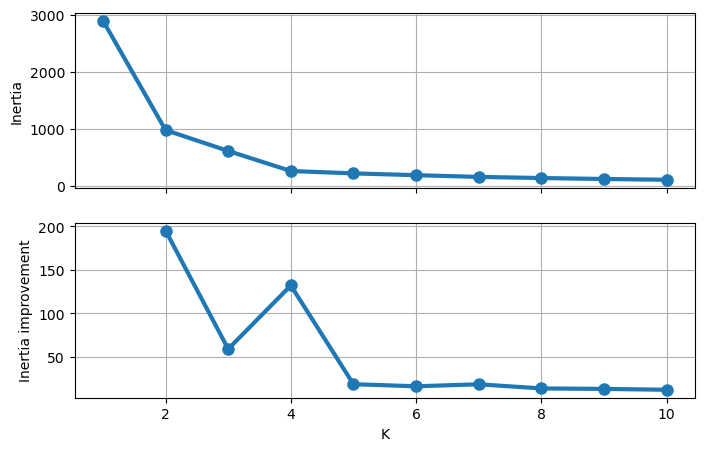

In [40]:
ensemblesize=100
maxK=10
best_cost = K_iteration(D, ensemblesize, maxK,random_seed=452)

fig, ax = plt.subplots(figsize=(8,5),nrows=2,sharex=True)

ax[0].plot(range(1,maxK+1),best_cost,
         linewidth=3,
         marker='o',
         markersize=8)
ax[0].grid()
ax[0].set_ylabel('Inertia')

ax[1].plot(range(2,maxK+1),100*np.abs(np.diff(best_cost)) / best_cost[1:],
         linewidth=3,
         marker='o',
         markersize=8)
ax[1].grid()
ax[1].set_ylabel('Inertia improvement')
ax[1].set_xlabel('K')

In [42]:
Kideal = 4

In [43]:
grader.check("q11")

q11 results: All test cases passed!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [44]:
grader.check_all()

q1 results: All test cases passed!

q10 results: All test cases passed!

q11 results: All test cases passed!

q3 results: All test cases passed!

q4 results: All test cases passed!

q6 results: All test cases passed!

q7 results: All test cases passed!

q8 results: All test cases passed!

q9 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Make sure you submit the .zip file to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)